Colorspace and architecture: https://arxiv.org/abs/2204.02850  
Fully Convolutional Networks: https://arxiv.org/pdf/1411.4038.pdf

Jetson nano: 0.236 TFLOPS fp32

Image colorization on youtube: https://youtu.be/WXyeQeHUxpc?si=jQfcU8Ra4StxFOwT

Youtube code: https://colab.research.google.com/drive/1BsqM7GBTtsyBixy2jsLGJNiSvp1ocpV7?usp=sharing


In [25]:
! pip install torchprofile 1>/dev/null
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs # Helps us to obtain mac calculations

import torch.nn.functional as F
import os
from torch.utils.data import Dataset
from PIL import Image

print("Testing if GPU is available.")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used.")
else:
    device = torch.device("cpu")
    print("GPU is not available, Falling back to CPU.")

os.chdir("/home/aaron/git/ImageColorization/")
BASEADDR = os.getcwd()
print(f"Current working directory: {BASEADDR}")

BATCH_SIZE = 32


Testing if GPU is available.
GPU is available and being used.
Current working directory: /home/aaron/git/ImageColorization


# Download and unpack imagenet64 database
imagenet64 is the imagenet database with each image scaled to be 64 by 64 pixels.

In [26]:

checkpoints = f"{BASEADDR}/checkpoints/scaleNet"
content = f"{BASEADDR}/content/"
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

import shutil
if not os.path.exists(content):
    os.makedirs(content)
if not os.path.exists(f'{content}/imagenet64'):
  os.chdir(content)
  if not os.path.exists(content + 'imagenet64.tar'):
    print("Downloading archive...")
    !wget https://pjreddie.com/media/files/imagenet64.tar
  print("Uncompressing...")
  !tar -xf imagenet64.tar

print("Data ready!")

Data ready!


In [27]:
class ColorizationDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load color image
        color_img, _ = self.dataset[idx]

        # Convert color image to grayscale
        gray = transforms.Grayscale()
        grayscale_img = gray(color_img)

        return grayscale_img, color_img


In [28]:
def get_imagenet64_data(batchSize):
  ## transformations
  ##transform = transforms.Compose(
    ##  [transforms.Resize(64), transforms.RandomHorizontalFlip(), transforms.ToTensor().to(device)])

  transform=transforms.Compose([
                             transforms.RandomResizedCrop(64, scale=(1.0, 1.0), ratio=(1., 1.)),
                              transforms.RandomHorizontalFlip(),
                              #transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
                              transforms.ToTensor(),
                              #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                          ])

  ## download and load training dataset
  trainSet = torchvision.datasets.ImageFolder(root=f'{content}/imagenet64/train/', transform=transform)
  colorizationTrainSet = ColorizationDataset(trainSet)
  trainLoader = DataLoader(colorizationTrainSet, batch_size=batchSize, shuffle=True, num_workers=2, pin_memory=True)

  ## download and load testing dataset
  testSet = torchvision.datasets.ImageFolder(root=f'{content}/imagenet64/val/', transform=transform)
  colorizationTestSet = ColorizationDataset(testSet)
  testloader = torch.utils.data.DataLoader(colorizationTestSet, batch_size=batchSize, shuffle=False, num_workers=2, pin_memory=True)
  return {'train': trainLoader, 'test': testloader}

In [29]:
class GrayNet_scaling(nn.Module):
    def __init__(self, layers=5):
        super(GrayNet_scaling, self).__init__()
        self.layers = layers
        channels = 16

        self.convDown = nn.ModuleList()
        self.convDown.append(nn.Conv2d(1, channels, 3, padding=1))

        for l in range(0, self.layers):
            self.convDown.append(nn.Conv2d(channels*pow(2, (l)), channels*pow(2, (l+1)), 3, padding=1))

        self.convUp = nn.ModuleList()
        self.convUp.append(nn.Conv2d(channels*pow(2, self.layers), channels*pow(2, self.layers-1), 3, padding=1))

        for l in range(self.layers-1, 0, -1):
            self.convUp.append(nn.Conv2d(channels*pow(2, (l))*2, channels*pow(2, (l-1)), 3, padding=1))

        self.convUp.append(nn.Conv2d(channels*2, 3, 3, padding=1))

    def forward(self, x):
        x = [x]
        for l in range(0, len(self.convDown)):
            x.append(F.relu(self.convDown[l](x[l])))

        x.append(F.relu(self.convUp[0](x[len(self.convDown)])))
        
        for l in range(1, len(self.convUp)):
            inp = torch.cat((x[len(self.convDown)-l], x[-1]),1)
            x.append(F.relu(self.convUp[l](inp)))

        return x[-1]
testInput = torch.randn(1,1,64,64).to(device)
testNetwork = GrayNet_scaling(1).to(device)
print(testNetwork)
print(testNetwork(testInput))

GrayNet_scaling(
  (convDown): ModuleList(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (convUp): ModuleList(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)
tensor([[[[0.1218, 0.0413, 0.1860,  ..., 0.0000, 0.0000, 0.0000],
          [0.1560, 0.1438, 0.1182,  ..., 0.1032, 0.0000, 0.0000],
          [0.0214, 0.0000, 0.1198,  ..., 0.1138, 0.1026, 0.0000],
          ...,
          [0.2683, 0.0000, 0.0000,  ..., 0.0408, 0.0000, 0.0000],
          [0.1624, 0.1969, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0284, 0.1150, 0.0582,  ..., 0.0000, 0.0354, 0.0000]],

         [[0.1716, 0.0000, 0.0000,  ..., 0.0000, 0.0533, 0.0000],
          [0.0829, 0.0992, 0.3339,  ..., 0.0027, 0.0394, 0.0000],
          [0.1953, 0.0869, 0.0189,  ..., 0.0000, 0.0000, 0.0426],
          ...,

In [30]:
def initialEvaluate(architecture, data_loader, test_loader, num_epochs=5):
    # Assuming you have access to labeled training data and a loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(architecture.parameters(), lr=0.001)

    architecture.to(device, non_blocking=True)
    for epoch in range(num_epochs):
        print("\tepoch: ", epoch+1, "/", num_epochs)
        for inputs, targets in tqdm(data_loader, leave=False):
            optimizer.zero_grad()
            outputs = architecture(inputs.to(device, non_blocking=True))
            loss = criterion(outputs, targets.to(device, non_blocking=True))
            loss.backward()
            optimizer.step()

    # After training, assess the performance on a validation set or the entire dataset
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, leave=False):
            outputs = architecture(inputs.to(device, non_blocking=True))
            loss = criterion(outputs, targets.to(device, non_blocking=True))
            total_loss += loss.item() * len(targets)
            total_samples += len(targets)

    average_loss = total_loss / total_samples
    return -average_loss  # Return the negative loss as a fitness score for maximization

# Initialize model and dataset

In [31]:
data = get_imagenet64_data(BATCH_SIZE)
trainLoader = data['train']#enumerate(data['train'])#iter(data['train'])
testLoader = data['test']#enumerate(data['test'])#iter(data['test'])

### Save model to file

In [32]:
# Save current model to file
def saveModel(state, savePath):
    if not os.path.exists(os.path.dirname(savePath)):
        os.makedirs(os.path.dirname(savePath))
    torch.save(state, savePath)



### Load existing model

### Visualize the data fed into the network

In [33]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

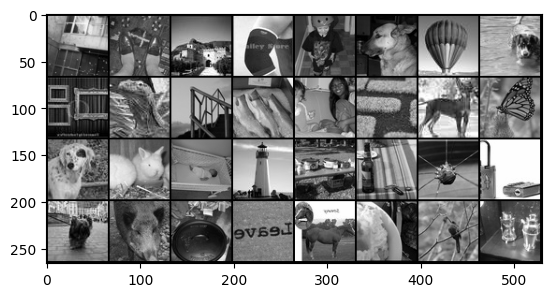

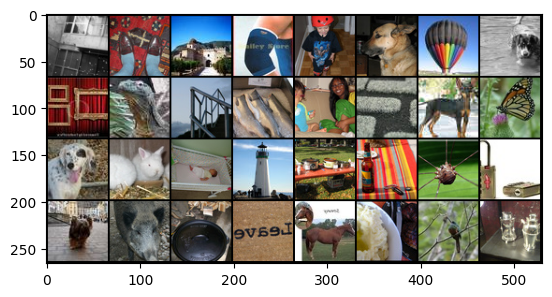

In [34]:
def visualizeData(dataLoader: DataLoader):
    inputs, targets = next(iter(dataLoader))

    # show grayscale images.
    imshow(torchvision.utils.make_grid(inputs))
    
    # show original images.
    imshow(torchvision.utils.make_grid(targets))

visualizeData(trainLoader)

In [35]:
def visualizeNetwork(model: nn.Module, dataLoader: DataLoader):
    inputs, targets = next(iter(dataLoader))

    # show grayscale images.
    imshow(torchvision.utils.make_grid(inputs))

    # show colorized images.
    outputs = model(inputs.to(device))
    imshow(torchvision.utils.make_grid(outputs.cpu()))
    
    # show original images.
    imshow(torchvision.utils.make_grid(targets))


### Train the network.

Testing network of size:  1
	epoch:  1 / 3


  0%|          | 0/40037 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


	epoch:  2 / 3


  0%|          | 0/40037 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(
/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


	epoch:  3 / 3


  0%|          | 0/40037 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2338aac1f0>
Traceback (most recent call last):
  File "/home/aaron/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/aaron/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2338aac1f0>
Traceback (most recent call last):
  File "/home/aaron/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    s

  0%|          | 0/1563 [00:00<?, ?it/s]

Model of depth  4  had accuracy of  -1.449503223590851  and is saved  /home/aaron/git/ImageColorization/checkpoints/scaleNet0/1.pt


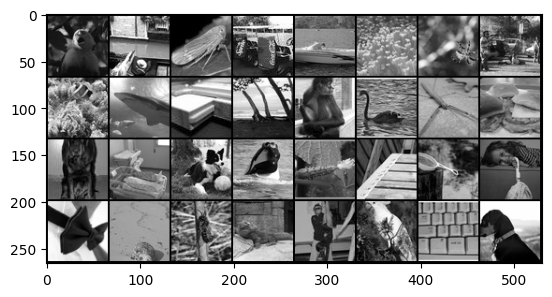

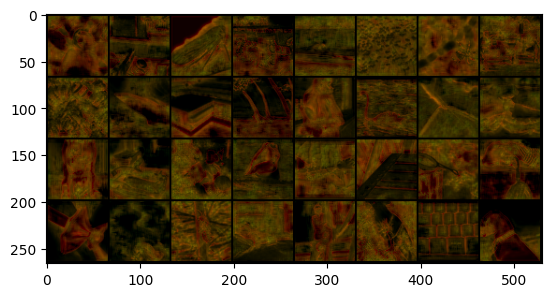

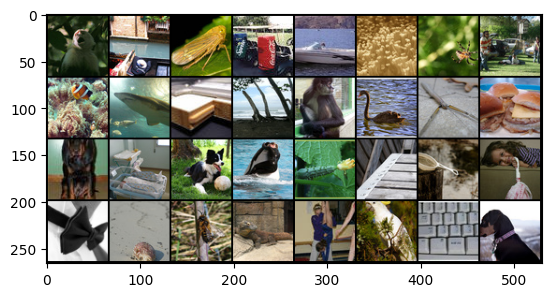

Testing network of size:  2
	epoch:  1 / 3


  0%|          | 0/40037 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(
/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


	epoch:  2 / 3


  0%|          | 0/40037 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(
/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


	epoch:  3 / 3


  0%|          | 0/40037 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


  0%|          | 0/1563 [00:00<?, ?it/s]

Model of depth  6  had accuracy of  -1.4492847756195069  and is saved  /home/aaron/git/ImageColorization/checkpoints/scaleNet0/2.pt


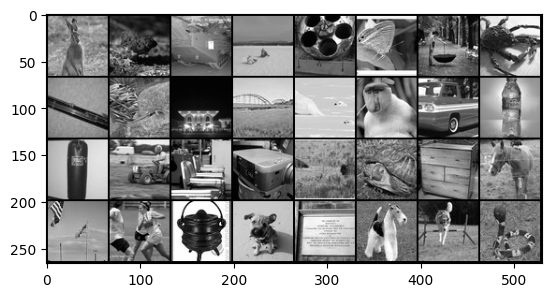

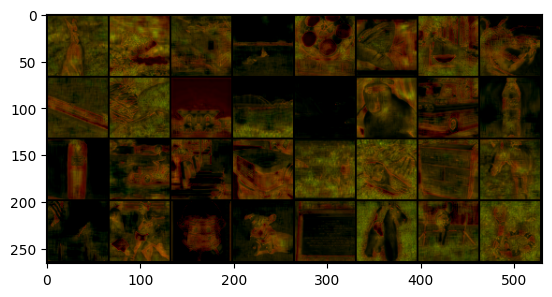

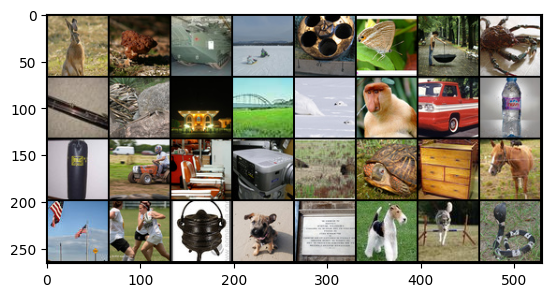

Testing network of size:  3
	epoch:  1 / 3


  0%|          | 0/40037 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(
/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


	epoch:  2 / 3


  0%|          | 0/40037 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(
/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


	epoch:  3 / 3


  0%|          | 0/40037 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


  0%|          | 0/1563 [00:00<?, ?it/s]

Model of depth  8  had accuracy of  -1.4488060719490052  and is saved  /home/aaron/git/ImageColorization/checkpoints/scaleNet0/3.pt


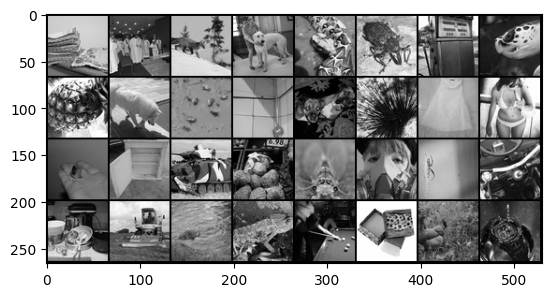

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


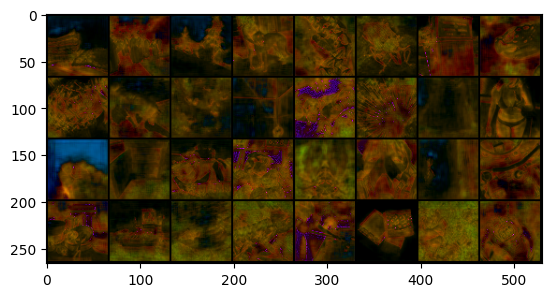

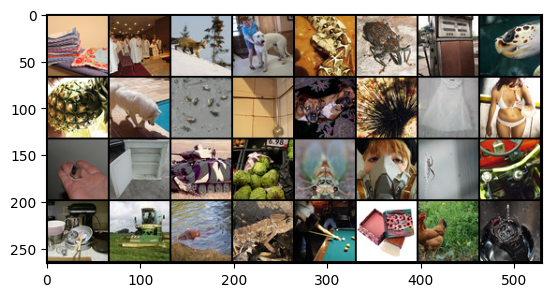

Testing network of size:  4
	epoch:  1 / 3


  0%|          | 0/40037 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


	epoch:  2 / 3


  0%|          | 0/40037 [00:00<?, ?it/s]

/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(
/usr/lib/python3/dist-packages/PIL/TiffImagePlugin.py:628: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  warnings.warn(


	epoch:  3 / 3


  0%|          | 0/40037 [00:00<?, ?it/s]

: 

In [36]:
VERSION = 0

max_net_size = 6
num_epochs = 3

for net_size in range(1,max_net_size):
    print("Testing network of size: ", net_size)
    model = GrayNet_scaling(net_size)
    accuracy = initialEvaluate(model, trainLoader, testLoader, num_epochs=num_epochs)
    save_path = f"{checkpoints}{VERSION}/{net_size}.pt"
    saveModel(model.state_dict(), save_path)
    print("Model of depth ", (net_size+1)*2, " had accuracy of ", accuracy, " and is saved ", save_path)
    visualizeNetwork(model, trainLoader)


In [ ]:
# Load model from file.
loadPath = f"{checkpoints}0/16.pt"
model.load_state_dict(torch.load(loadPath))
recover_model = lambda: model.load_state_dict(torch.load(loadPath))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


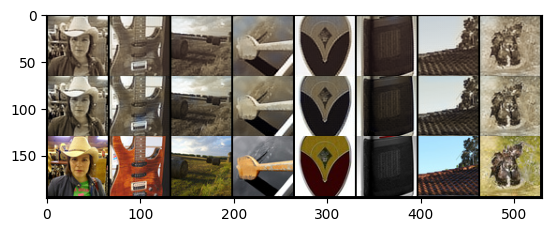

In [ ]:
def compareNetworks(model: nn.Module, dataLoader: DataLoader, net1: str, net2: str):
    data = get_imagenet64_data(8)
    inputs, targets = next(iter(data['train']))

    # Save original state of model.
    originalState = model.state_dict()

    # get colorized images from networks.
    model.load_state_dict(torch.load(net1))
    outputs1 = model(inputs.to(device))
    model.load_state_dict(torch.load(net2))
    outputs2 = model(inputs.to(device))

    # Display colorized images alongside true image.
    imshow(torchvision.utils.make_grid(torch.cat((outputs1.cpu(), outputs2.cpu(), targets),2)))
    
    # Load original state back into model.
    model.load_state_dict(originalState)

compareNetworks(model, trainLoader, f"{checkpoints}0/0.pt", f"{checkpoints}0/16.pt")